In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import re
import statistics

plt.style.use('ggplot')

# Args

In [2]:
def get_unique_entries(df):
    return np.where((df.cdr3_TRA==a) & (df.cdr3_TRB==b), False, True)

In [3]:
def add_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T
    
    return mat_a.add(mat_b)

In [4]:
def get_intra_similarity(cdr3_TRAs, cdr3_TRBs):
    unique_entries = get_unique_entries(group) #np.where((group.cdr3_TRA==a) & (group.cdr3_TRB==b), False, True)
    
    intra_a = group[unique_entries].cdr3_TRA
    intra_b = group[unique_entries].cdr3_TRB
    
    combined_similarity = add_similarity_scores(intra_a, intra_b) #np.delete(cdr3_TRAs, index), np.delete(cdr3_TRBs, index)
    
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

In [5]:
def get_inter_similarity(cdr3_TRAs, cdr3_TRBs):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity!
    sample_size = sum(get_unique_entries(group))
    unique_entries =  get_unique_entries(inter_chains) #np.where((inter_chains.cdr3_TRA==a) & (inter_chains.cdr3_TRB==b), False, True)
    
    inter_sample = random.sample(inter_chains[unique_entries].index.to_list(), sample_size)
    
    inter_a = inter_chains.loc[inter_sample, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[inter_sample, 'cdr3_TRB'].values
    
    combined_similarity = add_similarity_scores(inter_a, inter_b)
    
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

In [133]:
def get_sample_size():
    inter_entries = get_unique_entries(inter_chains)
    inter_indexes = inter_chains[inter_entries].index.to_list()
    return min(sum(get_unique_entries(group)), len(inter_indexes))

def get_intra_similarity(cdr3_TRAs, cdr3_TRBs):
    unique_entries = get_unique_entries(group)
    unique_entry_indexes = group[unique_entries].index.to_list()

    sample_size = get_sample_size()

    intra_sample = random.sample(unique_entry_indexes, sample_size)
    intra_a = group.loc[intra_sample, 'cdr3_TRA'].values
    intra_b = group.loc[intra_sample, 'cdr3_TRB'].values
    combined_similarity = add_similarity_scores(intra_a, intra_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def get_inter_similarity(cdr3_TRAs, cdr3_TRBs):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity! 
    unique_entries = get_unique_entries(inter_chains)
    unique_entry_indexes = inter_chains[unique_entries].index.to_list()

    sample_size = get_sample_size()

    inter_sample = random.sample(unique_entry_indexes, sample_size)
    inter_a = inter_chains.loc[inter_sample, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[inter_sample, 'cdr3_TRB'].values
    combined_similarity = add_similarity_scores(inter_a, inter_b) 
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

In [6]:
def paired_t_test(x1 ,x2):
    assert len(x1) == len(x2)
    
    statistic, pvalue = stats.ttest_rel(x1, x2)
    
    if (pvalue/2.0 < 0.05) & (statistic > 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}

In [7]:
def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        median = statistics.median(lst)
        plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

In [8]:
def add_significance_bar(intra_lst, inter_lst):
    t = paired_t_test(intra_lst, inter_lst)#['pvalue']
    
    if t['test'] and t['pvalue'] < 0.05:
        pass
    else:
        return
    
    y0 =  max(max(intra_lst), max(inter_lst))
    y1 = y0 * 1.02
    y2 = y0 * 1.025
    y3 = y0 * 1.03
    y4 = y0 * 1.035

    plt.plot([1,1,2,2], [y1,y2,y2,y1], lw=1.5, c='k')
    plt.text(1.5, y3, "p = %.6f" %t['pvalue'], ha='center', va='bottom', color='k')
    plt.plot(1, y4)

In [10]:
def plot_boxplot(intra_lst, inter_lst, title):
    
    plt.figure(figsize=(3,5))
    plt.boxplot([intra_lst, inter_lst], labels=['intra', 'inter'], widths=(0.5, 0.5))
    
    plt.title(title)
    plt.xlim(0.6, 2.4)
    #plt.ylim(-0.1, 2.1)
    plt.ylabel("Similarity")
    
    add_number_of_observations(intra_lst, inter_lst)
    add_significance_bar(intra_lst, inter_lst)
    #plt.savefig(directory + 'boxplot_{}.pdf'.format(title), bbox_inches='tight')
    plt.show()

In [11]:
def plot_pieplot(significance_count, total_peptides):
    plt.pie([sum(significance_count), total_peptides-sum(significance_count)],
            labels=['significant difference', 'insignificant'],
            autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * total_peptides / 100, p))
    plt.title("Distribution of significant outcomes (%i)" %total_peptides)
    #plt.savefig(directory + 'pieplot.pdf', bbox_inches='tight')
    plt.show()

In [98]:
EXP = "exp3"

In [99]:
#TYPE = 'imputed_new-clonotype'

In [100]:
#directory = "stats/{}/{}/".format(EXP, TYPE)

# Input

In [101]:
##INPUT_DISC = 'tcr_barcode.cleaned.imputed.nonimputed_discarded.csv'
#if TYPE == 'imputed_new-clonotype':
#    INPUT = 'tcr_barcode.cleaned.imputed.{}.csv'.format(EXP)
#elif TYPE == 'non-imputed_new-clonotype':
#    INPUT = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv"

In [102]:
INPUT = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.imputed.csv"

In [237]:
UNIQUE_GEM = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_CAT_IONTORRENT_KMA_AKB/specificity_matrix/peptide_per_clonotype_by_gem_size/ct/umi_delta0/no_filtration/unique_gems/b4.t2.ecs_False.ess_False.lst"

In [238]:
SIM_TRA    = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_tra.{}.tab".format(EXP)
SIM_TRB    = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_trb.{}.tab".format(EXP)

In [239]:
PEPTIDES   = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3.2.2_MHC_IONTORRENT/barcode_library/barcode_specificity_annotations.xlsx"

# Output

# Load

In [240]:
unique_gems = np.loadtxt(UNIQUE_GEM, dtype=str)

In [241]:
df = pd.read_csv(INPUT)
df = df[df.gem.isin(unique_gems)]

In [242]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0)
sim_trb = pd.read_csv(SIM_TRB, index_col=0)

sim_tra = sim_tra[~sim_tra.index.duplicated()]
sim_trb = sim_trb[~sim_trb.index.duplicated()]

In [243]:
input_peptides = pd.read_excel(PEPTIDES)
total_peptides = len(input_peptides.Sequence.unique()) - 1

# Process

In [244]:
df.shape[0]

559

In [245]:
df = df.replace('unknown', np.nan).dropna(subset=['cdr3_TRA', 'cdr3_TRB'])

# Main

In [246]:
intra_score = list()
inter_score = list()
intra_fract = list()
inter_fract = list()

significant_simulations = list()
for simulation in range(5):
    significant_count = 0

    significant_scores = list()
    significant_fracts = list()

    for peptide, group in df.groupby('peptide_HLA'):
        if len(group) == 1:
            continue
        if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
            continue

        inter_chains = df.loc[df.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

        intra_score_peptide = list()
        inter_score_peptide = list()  
        intra_fract_peptide = list()
        inter_fract_peptide = list()

        cdr3_TRAs = group.cdr3_TRA.values
        cdr3_TRBs = group.cdr3_TRB.values

        for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):  
            intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
            inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

            intra_score_peptide.append(intra['score'])
            inter_score_peptide.append(inter['score'])
            intra_fract_peptide.append(intra['fraction'])
            inter_fract_peptide.append(inter['fraction'])

            intra_score.append(intra['score'])
            inter_score.append(inter['score'])
            intra_fract.append(intra['fraction'])
            inter_fract.append(inter['fraction'])

        #plot_boxplot(intra_score_peptide, inter_score_peptide, peptide + ' score')
        #plot_boxplot(intra_fract_peptide, inter_fract_peptide, peptide + ' fraction')

        # Statistics
        # Calc p-value for each peptide-plateau (count number of intra significant peptide-plateaus)
        # Count fraction of GEMs above 1.8 similarity
        
        significant_scores.append(paired_t_test(intra_score_peptide, inter_score_peptide)['test'])
        significant_fracts.append(paired_t_test(intra_fract_peptide, inter_fract_peptide)['test'])
        
        if paired_t_test(intra_score_peptide, inter_score_peptide)['test']:
            significant_count += 1
            print(len(intra_score_peptide), len(inter_score_peptide))
    significant_simulations.append(significant_count)
    print(significant_simulations)
significant_count = statistics.median(significant_simulations)

        

42 42
37 37
42 42
209 209
27 27
[5]
42 42
37 37
42 42
209 209
[5, 4]
42 42
37 37
42 42
209 209
[5, 4, 4]
42 42
37 37
42 42
209 209
27 27
[5, 4, 4, 5]
42 42
37 37
42 42
209 209
[5, 4, 4, 5, 4]


In [37]:
significant_count

14

In [38]:
sum(significant_scores)

14

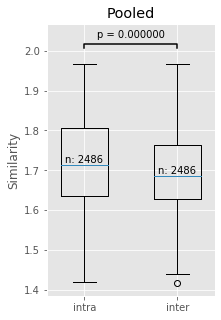

In [27]:
plot_boxplot(intra_score, inter_score, 'Pooled') 

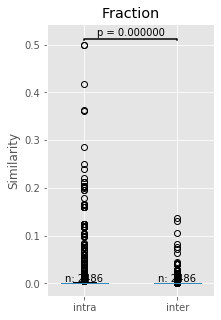

In [28]:
plot_boxplot(intra_fract, inter_fract, 'Fraction')

In [32]:
significant_scores

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True]

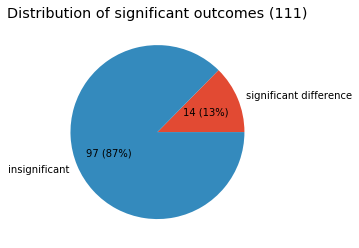

In [31]:
plot_pieplot(significant_scores, total_peptides)

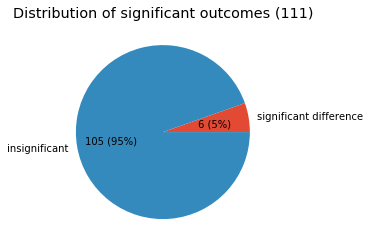

In [47]:
plot_pieplot(fract_significance, total_peptides, 'Fraction')

In [48]:
TYPE

'imputed_new-clonotype'

# All imputed

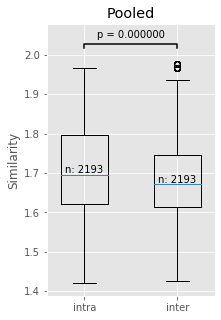

In [22]:
plot_boxplot(intra_score, inter_score, 'Pooled') 

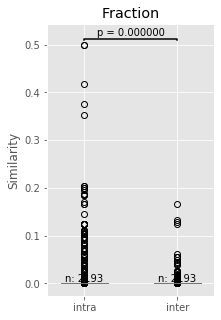

In [23]:
plot_boxplot(intra_fract, inter_fract, 'Fraction')

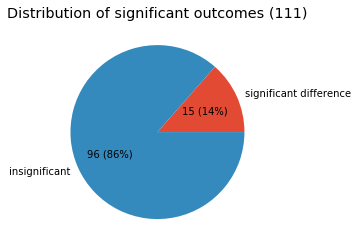

In [24]:
plot_pieplot(score_significance, total_peptides)

In [25]:
sum(score_significance) / total_peptides

0.13513513513513514

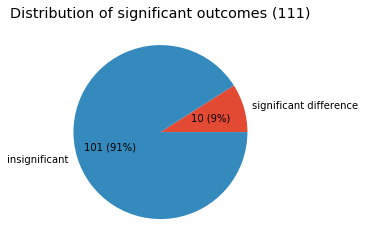

In [26]:
plot_pieplot(fract_significance, total_peptides)

In [27]:
sum(fract_significance) / total_peptides

0.09009009009009009